# LSTM Model for American Sign Language Recognition

#### NOTE: Please ensure that all packages or Libraries are installed

In [1]:
!pip install tensorflow tensorflow-gpu opencv-python mediapipe sklearn matplotlib gingerit cloudscraper 

  Using cached opencv_python-4.6.0.66-cp36-abi3-win_amd64.whl (35.6 MB)
  Using cached sklearn-0.0-py2.py3-none-any.whl
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached opencv_contrib_python-4.6.0.66-cp36-abi3-win_amd64.whl (42.5 MB)
  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl (2.4 kB)
  Using cached tensorboard_plugin_wit-1.8.1-py3-none-any.whl (781 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cached requests_oauthlib-1.3.1-py2.py3-none-any.whl (23 kB)


# 1. Import Dependencies & Set Directories

In [2]:
import cv2
import os
import time
import json
import nltk
import pickle
import tensorflow
import mediapipe as mp
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from pathlib import Path
from scipy import stats
from IPython.display import clear_output




cwd = os.getcwd()
frameCap = 15
print(cwd)

C:\Users\User\Desktop\FYP ASL Project\Project Folder\LSTM Model


# 2. Keypoints using MP HolisticModel

In [21]:
# Remember to initialize the code below before running any prediction
mediapipe_HolisticModel_Model = mp.solutions.holistic # HolisticModel model
mediapipe_Draw_Landmarks = mp.solutions.drawing_utils # Drawing utilities

In [22]:
def mediapipe_HolisticModel_Detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False                 
    res = model.process(image)               
    image.flags.writeable = True                  
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, res

In [23]:
def draw_Landmarks_To_Image(image, res):
    
    # Right hand landmarks 
    mediapipe_Draw_Landmarks.draw_landmarks(image, res.right_hand_landmarks, mediapipe_HolisticModel_Model.HAND_CONNECTIONS, 
                             mediapipe_Draw_Landmarks.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mediapipe_Draw_Landmarks.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 
    
    # Left hand landmarks
    mediapipe_Draw_Landmarks.draw_landmarks(image, res.left_hand_landmarks, mediapipe_HolisticModel_Model.HAND_CONNECTIONS, 
                             mediapipe_Draw_Landmarks.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mediapipe_Draw_Landmarks.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             )

##  2.1 Identify Camera Port

Run this function to identify which camera port is available on your specific device, default laptop webcam maybe set to 0

In [24]:
def find_CameraPort():
    # Test the ports and returns a tuple with the available ports and the ones that are working.
    # Output allows users to know which camera port is available on their devices
    is_working = True
    devicePort = 0
    working_ports = []
    available_ports = []
    while is_working:
        camera = cv2.VideoCapture(devicePort)
        if not camera.isOpened():
            is_working = False
            print(f'Device port {devicePort} failed to respond')
        else:
            is_reading, img = camera.read()
            w = camera.get(3)
            h = camera.get(4)
            if is_reading:
                print(f'Port {devicePort} works and can read images [{h} x {w}]')
                working_ports.append(devicePort)

        devicePort += 1

    return working_ports

find_CameraPort()

Port 0 works and can read images [480.0 x 640.0]
Port 1 works and can read images [480.0 x 640.0]
Port 2 works and can read images [480.0 x 640.0]
Device port 3 failed to respond


[0, 1, 2]

## 2.2 Live Video Input

Note: If camera does not start on your machine, try switching between working number ports listed in section 2.1 under <br>
**cap = cv2.VideoCapture( [Change Number Here] )**

In [23]:
cap = cv2.VideoCapture(1)

# Set mediapipe model 
with mediapipe_HolisticModel_Model.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as HolisticModel:
    while cap.isOpened():

        # Get camera feed
        ret, frame = cap.read()

        # Hand detections
        image, res = mediapipe_HolisticModel_Detection(frame, HolisticModel)
        
        # Draw hand gesture landmarks
        draw_Landmarks_To_Image(image, res)

        # Display
        cv2.imshow('Live Feed', image)

        # wait for 10 milliseconds and Break when 'ESC' is pressed
        if cv2.waitKey(1) & 0xFF == 27:
            break
            
    cap.release()
    cv2.destroyAllWindows()

<br>Once you have identified your desired camera port to use in this applicaiton, set the prefered port to be used throughout the program below. <br>
**cameraPort = setCameraPort( [Change Number Here] )**

In [25]:
def setCameraPort(portNumber = 0):
    cameraPort = portNumber
    return cameraPort

cameraPort = setCameraPort(1)
print(f'Camera port set to: {cameraPort}')

Camera port set to: 1


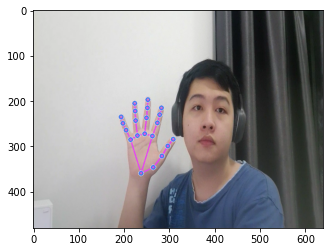

In [25]:
# Sample of working hand detected image
draw_Landmarks_To_Image(frame, res)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values

### Data Exploration and Understanding

In [31]:
print(res.right_hand_landmarks)

landmark {
  x: 0.37227532
  y: 0.7494945
  z: 2.950014e-07
}
landmark {
  x: 0.41519886
  y: 0.7221193
  z: -0.01427071
}
landmark {
  x: 0.44466326
  y: 0.6696658
  z: -0.017828057
}
landmark {
  x: 0.46538973
  y: 0.6233819
  z: -0.021249305
}
landmark {
  x: 0.48402268
  y: 0.593477
  z: -0.024224006
}
landmark {
  x: 0.4113148
  y: 0.5784809
  z: -0.0029761514
}
landmark {
  x: 0.42862388
  y: 0.5177083
  z: -0.0113224685
}
landmark {
  x: 0.43692005
  y: 0.47960457
  z: -0.019784862
}
landmark {
  x: 0.44264552
  y: 0.44838017
  z: -0.026597695
}
landmark {
  x: 0.3850705
  y: 0.56863385
  z: -0.00481187
}
landmark {
  x: 0.3907108
  y: 0.49495125
  z: -0.01224877
}
landmark {
  x: 0.39467922
  y: 0.4490226
  z: -0.020414438
}
landmark {
  x: 0.39650944
  y: 0.41214615
  z: -0.026513712
}
landmark {
  x: 0.36045742
  y: 0.575335
  z: -0.00948511
}
landmark {
  x: 0.35393253
  y: 0.50704306
  z: -0.01914304
}
landmark {
  x: 0.3523031
  y: 0.4643734
  z: -0.028557207
}
landmark {


Based on the plot image shown above, each circle drawn on my hand is called a landmark <br>
Each landmark has their specific x,y,z values, this would be the fundamental data required to train the model

In [35]:
print(f'Number of landmarks (right hand): {len(res.right_hand_landmarks.landmark)}')

Number of landmarks (right hand): 21


In [36]:
len(res.left_hand_landmarks.landmark)

AttributeError: 'NoneType' object has no attribute 'landmark'

<br>Going back to the plot image shown in section 2.2, notice that only my right hand is present,<br> <br>
If there is no presence of hand(s) being detected, all 'NoneType' object would be treated with '0' as the default landmark value, which is the purpose of the get_Landmark_Values() function below.

In [26]:
def get_Landmark_Values(res):
    leftHand = np.array([[res.x, res.y, res.z] for res in res.left_hand_landmarks.landmark]).flatten() if res.left_hand_landmarks else np.zeros(21*3)
    rightHand = np.array([[res.x, res.y, res.z] for res in res.right_hand_landmarks.landmark]).flatten() if res.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([leftHand, rightHand])

Aside from handling missing values, the get_Landmark_Values() combines each landmark into one giant final array to represent a hand gesture

In [45]:
testRes = get_Landmark_Values(res)
# 21 landmarks * 3 (x,y,z) values = 63
# 63 * 2 (each hand) = 126 (data points)
print(f'Data shape: {testRes.shape}')
testRes

Data shape: (126,)


array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

Based on the numbers above, these numbers above represent the number '5' in American Sign Language

# 4. Setup Folders for Collection and File Handling

In [27]:
def get_VideoDuration():
        
    if not cap.isOpened(): 
        print("could not open :",path + videoFile)
        return None

    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) / frameCap)
    return length

In [28]:
# Used to save indexed word file, used at section 6 for creating and saving data labels
def save_label(dictionary, modelName):
    path = os.path.join(cwd, modelName, 'Labels.pkl')
    with open(path, 'wb') as labelFile:
        pickle.dump(dictionary, labelFile)

In [29]:
# Used to load file for model to search for predicted word label
# Would be used in the React Backend api for loading labeled data
def load_label(modelName):
    path = os.path.join(cwd, modelName, 'Labels.pkl')
    with open(path, 'rb') as labelFile:
        loaded_dict = pickle.load(labelFile)
        return loaded_dict

In [30]:
def get_dataset(fileName, mode):
    outside = os.path.normpath(cwd + os.sep + os.pardir)
    path = os.path.join(outside, 'Dataset', fileName, mode)
    dir_list = os.listdir(path)
    return path, dir_list


# 5. Feature Extraction (Landmarks) & Data collection

### Collecting Video Data

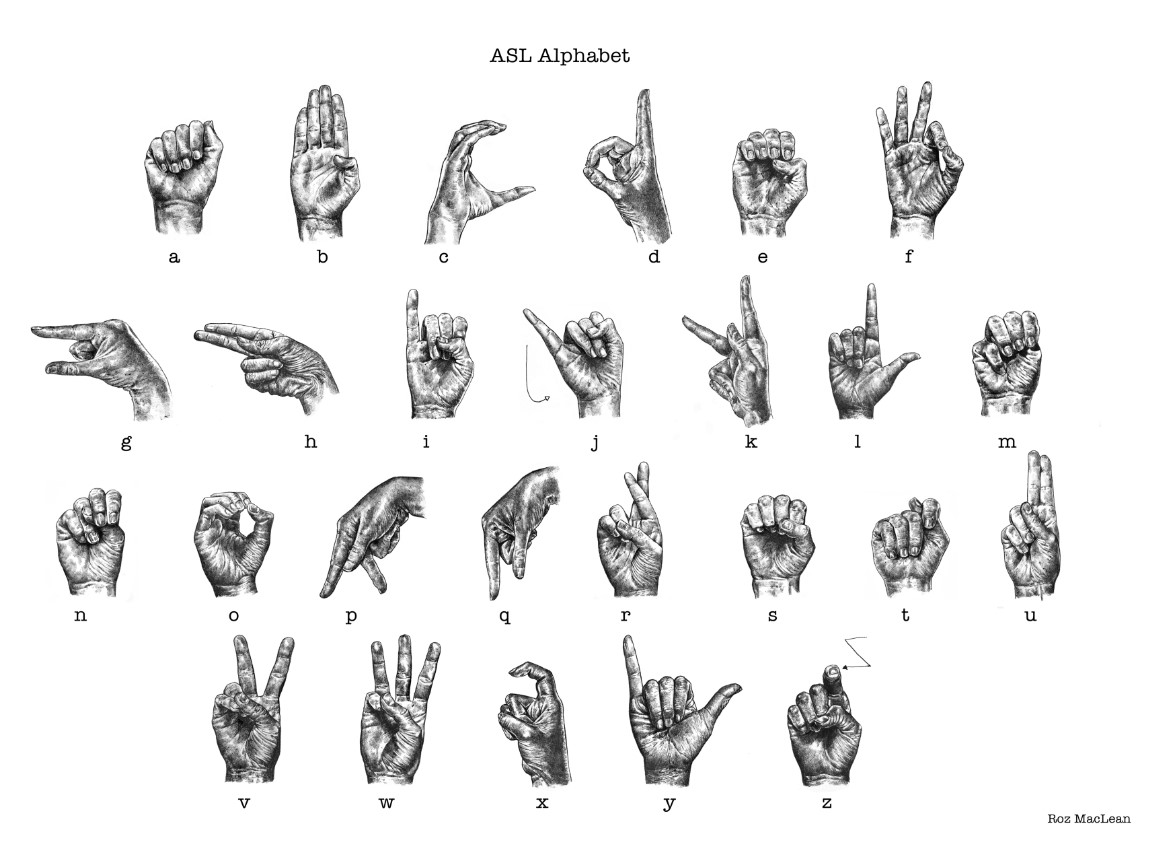 <br> (Maclean, 2016)

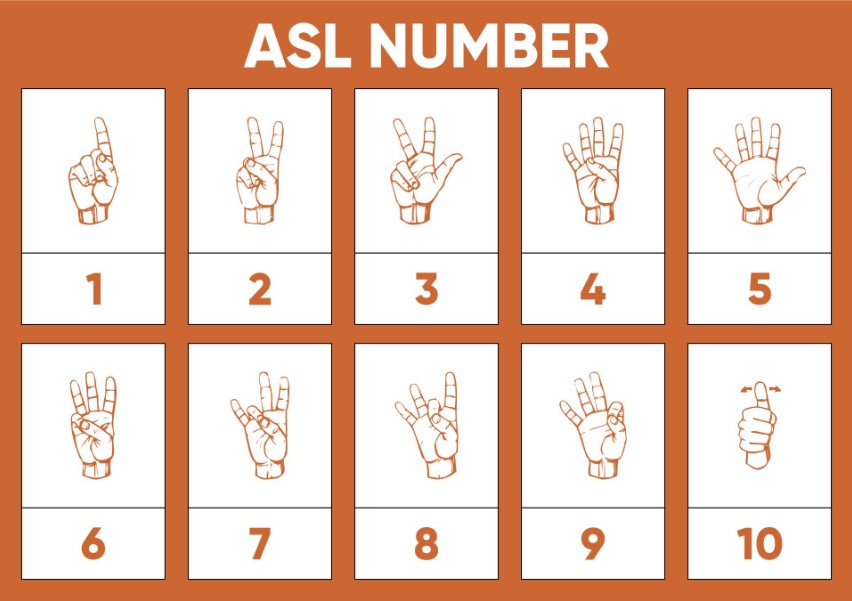 <br> (printablee, 2020)

The dataset that would be used to train the model would include self collected video data, hand gestures are referenced from the images above

In [31]:
def record_Video(DATASET_PATH):
    #Capture video from webcam
    vid_capture = cv2.VideoCapture(cameraPort)
    vid_cod = cv2.VideoWriter_fourcc(*'XVID')
    output = cv2.VideoWriter(DATASET_PATH, vid_cod, 30.0, (1280,720))
    vid_capture.set(3,1280)
    vid_capture.set(4,720)
    numberOfFrames = 0
    while(numberOfFrames < 1000):
        # Capture each frame of webcam video
        ret,frame = vid_capture.read()
        cv2.imshow("My Video Feed", frame)
        output.write(frame)
        numberOfFrames = numberOfFrames + 1

        # Close and break the loop after pressing "x" key
        if cv2.waitKey(10) &0XFF == ord('x'):           
            break
            
    cv2.waitKey(0)
    # close the already opened camera
    vid_capture.release()
    # close the already opened file
    output.release()
    # close the window and de-allocate any associated memory usage
    cv2.destroyAllWindows()

In [ ]:
for word in ['Z']:
    videoDirectory = os.path.join(cwd, 'Dataset', 'Alphabet', 'video', word)
    Path(videoDirectory).mkdir(parents=True, exist_ok=True)
    for videoNumber in range(1):
        PathDirectory = os.path.join(videoDirectory, "video_"+str(videoNumber+1)+".mp4")
        record_Video(PathDirectory)
print("[Data Collection Completed]")

### Personal Dataset feature extraction

In [70]:
from pathlib import Path
modelName = 'Vocabulary LSTM Model'
data_path, wordList = get_dataset("Alphabet", "video")
weight_path = os.path.join(cwd, modelName, 'weight')

with mediapipe_HolisticModel_Model.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as HolisticModel:
    for word in wordList:

        # Get list of videos for each word
        videoIndex = os.listdir(os.path.join(data_path, word))
        isExist = os.path.exists(os.path.join(weight_path, word))
        
        # Check if no video is present in the word file
        # Move on to next word if videos had already been processed
        if len(videoIndex) == 0:
            print("Skipping word {" + word+ "}: No video data")
        elif isExist == True:
            print("Word {" + word + "} has already been processed!")
        else:          
            videoCount = 0
            print("Processing {" + word + "}...")
            for video in videoIndex:

                # Get video
                videoDirectory = os.path.join(data_path, word, video)
                #videoDirectory = path + word + "\\" + video
                cap = cv2.VideoCapture(videoDirectory)
                length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                videoDuration = 0
                videoCount = videoCount + 1
                print("\t\t" + videoDirectory)

                frameCount = 0
                while cap.isOpened():
                    #Read feed
                    ret, frame = cap.read()

                    # Make detections
                    image, res = mediapipe_HolisticModel_Detection(frame, HolisticModel)

                    # Create directory
                    frameCount = frameCount + 1
                    path = os.path.join(cwd, modelName, 'weight', word, f'video_{str(videoCount)}')
                    Path(path).mkdir(parents=True, exist_ok=True)
                    saveResultDirectory = os.path.join(path, str(frameCount))

                    # Save res into newly created directory
                    keypoints = get_Landmark_Values(res)
                    np.save(saveResultDirectory, keypoints)

                    videoDuration = videoDuration + 1
                    if cv2.waitKey(1) & 0xFF == ord('q') or ret==False or videoDuration > length - 1:
                        cap.release()
                        cv2.destroyAllWindows()
                        print("\t\t" + "Completed!")
                        break
print("[Data Collection Completed]")

Processing {Books}...
		C:\Users\User\Desktop\FYP ASL Project\Project Folder\Dataset\Alphabet\video\Books\video_1.mp4
		Completed!
Processing {I}...
		C:\Users\User\Desktop\FYP ASL Project\Project Folder\Dataset\Alphabet\video\I\video_1.mp4
		Completed!
Processing {Meet}...
		C:\Users\User\Desktop\FYP ASL Project\Project Folder\Dataset\Alphabet\video\Meet\video_1.mp4
		Completed!
Processing {Name}...
		C:\Users\User\Desktop\FYP ASL Project\Project Folder\Dataset\Alphabet\video\Name\video_1.mp4
		Completed!
Processing {Nice}...
		C:\Users\User\Desktop\FYP ASL Project\Project Folder\Dataset\Alphabet\video\Nice\video_1.mp4
		Completed!
Processing {Read}...
		C:\Users\User\Desktop\FYP ASL Project\Project Folder\Dataset\Alphabet\video\Read\video_1.mp4
		Completed!
Processing {Whats}...
		C:\Users\User\Desktop\FYP ASL Project\Project Folder\Dataset\Alphabet\video\Whats\video_1.mp4
		Completed!
Processing {You}...
		C:\Users\User\Desktop\FYP ASL Project\Project Folder\Dataset\Alphabet\video\Y

## WLASL

### WLASL Loading Dataset

In [177]:
def Convert(string):
    li = list(string.split("\n"))
    return li

In [178]:
# List of missing video data from WLASL
def get_missingWLASLVideoList(path):
    with open(path) as f:
        missingVideoID = f.read()
        missingVideoIDList = Convert(missingVideoID)
        f.close()
        return missingVideoIDList

In [179]:
outside = os.path.normpath(cwd + os.sep + os.pardir)
WLASL_filePath = os.path.join(outside, 'Dataset','WLASL')
json_filePath = os.path.join(WLASL_filePath, 'WLASL_v0.3.json')

# returns JSON object as 
data = json.load(open(json_filePath))
missingVideoIDList = get_missingWLASLVideoList(os.path.join(WLASL_filePath, 'missing.txt'))

### WLASL dataset video data validation <dr>
    This part is used to validate that the video data is present listed from the "WLASL_v0.3.json" file

In [180]:
word,videoName,videoPath = [],[],[]

WLASL_VideoPath = os.path.join(WLASL_filePath, 'Vocabulary', 'videos')
print("Processing")
for i in range(0,5):
    print(data[i]['gloss'])
    for j in range(0,len(data[i]['instances'])):
        vid_ID = str(data[i]['instances'][j]['video_id'])
        # Check if there are any missing videos not present in missing data list
        if vid_ID not in missingVideoIDList and vid_ID is not None:
            vidPath = os.path.join(WLASL_VideoPath, vid_ID + ".mp4")
            isdir = os.path.exists(vidPath)           
            if isdir == True:
                word.append(data[i]['gloss'])
                videoName.append(vid_ID)
                videoPath.append(vidPath)
            else:
                print("Missing: " + vid_ID)
        
    print("==================================")
print(" *** Finished *** ")

Processing
book
Missing: 07074
drink
computer
before
chair
 *** Finished *** 


In [71]:
# Select only the first 3 videos of any related word (Save computation time)
def cut_DownDF(df):
    df_append = pd.DataFrame()
    for i in df['Word'].unique():
        x = df[df['Word']==i].head(1)
        df_append = pd.concat([df_append, x])
    return df_append
    

In [183]:
# initialize data of lists.
dfData = {'Word': word,
        'Video_ID': videoName,
        'Video_Path': videoPath
       }
  
# Create DataFrame
WLASL_df = pd.DataFrame(dfData)
WLASL_df.columns =[column.replace(" ", "_") for column in WLASL_df.columns]
WLASL_df = cut_DownDF(WLASL_df)
# Print the output.
WLASL_df

,Word,Video_ID,Video_Path
0,book,69241,C:\Users\User\Desktop\FYP ASL Project\Project ...
5,drink,69302,C:\Users\User\Desktop\FYP ASL Project\Project ...
20,computer,12328,C:\Users\User\Desktop\FYP ASL Project\Project ...
34,before,05728,C:\Users\User\Desktop\FYP ASL Project\Project ...
50,chair,09848,C:\Users\User\Desktop\FYP ASL Project\Project ...


# WLASL Dataset feature extraction

In [186]:
from pathlib import Path

modelName = 'Vocabulary LSTM Model'
with mediapipe_HolisticModel_Model.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as HolisticModel:
    wordList = list(WLASL_df.Word.unique())
    for word in wordList:

        isExist = os.path.exists(os.path.join(cwd, modelName, 'weight', word))
        # Move on to next word if videos had already been processed
        if isExist == True:
            print("Word {" + word + "} has already been processed!")
        else:
            print("Processing {" + word + "}...")
            videoCount = 0
            df = WLASL_df.copy(deep=False)
            df.query(f'Word == "{word}"',inplace = True)
            for videoDirectory in df['Video_Path'].tolist():

                # Get video
                #videoDirectory = r'C:\Users\User\Desktop\FYP ASL Project\WLASL\Vocabulary\videos\17720.mp4'
                cap = cv2.VideoCapture(videoDirectory)
                length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                videoDuration = 0
                videoCount = videoCount + 1
                #print("Processing {" + word + "}...") 
                print("\t\t" + videoDirectory)
                
                if videoCount > 3:
                    break
                   
                frameCount = 0
                while cap.isOpened():
                    try:
                        #Read feed
                        ret, frame = cap.read()

                        #Make detections
                        image, res = mediapipe_HolisticModel_Detection(frame, HolisticModel)

                        # Create directory
                        frameCount = frameCount + 1
                        
                        path = os.path.join(cwd, modelName, 'weight', word, f'video_{str(videoCount)}')
                        Path(path).mkdir(parents=True, exist_ok=True)
                        saveResultDirectory = os.path.join(path, str(frameCount))
                        
                        # Save res into newly created directory
                        keypoints = get_Landmark_Values(res)
                        np.save(saveResultDirectory, keypoints)

                        videoDuration = videoDuration + 1
                        if cv2.waitKey(1) & 0xFF == ord('q') or ret==False or videoDuration > length - 1:
                            cap.release()
                            cv2.destroyAllWindows()
                            print("\t\t" + "Completed!")
                            break
                    except:
                        print("\t\t" + "Error has occured")
                        cap.release()
                        cv2.destroyAllWindows()
                        break
print("[Data Collection Completed]")

Processing {book}...
		C:\Users\User\Desktop\FYP ASL Project\Project Folder\Dataset\WLASL\volcabulary\videos\69241.mp4
		Completed!
Processing {drink}...
		C:\Users\User\Desktop\FYP ASL Project\Project Folder\Dataset\WLASL\volcabulary\videos\69302.mp4
		Completed!
Processing {computer}...
		C:\Users\User\Desktop\FYP ASL Project\Project Folder\Dataset\WLASL\volcabulary\videos\12328.mp4
		Completed!
Processing {before}...
		C:\Users\User\Desktop\FYP ASL Project\Project Folder\Dataset\WLASL\volcabulary\videos\05728.mp4
		Completed!
Processing {chair}...
		C:\Users\User\Desktop\FYP ASL Project\Project Folder\Dataset\WLASL\volcabulary\videos\09848.mp4
		Completed!
[Data Collection Completed]


# 6. Preprocess Data and Create Labels and Features

In [20]:
modelName = 'Vocabulary LSTM Model'
path = os.path.join(cwd, modelName, 'weight')
dir_list = os.listdir(path)
print(path)

# Create integer labels to represent each word
label_map = {label:num for num, label in enumerate(dir_list)}

# Would be used to save and load label data later on
save_label(label_map , modelName) 
print(load_label(modelName))

C:\Users\User\Desktop\FYP ASL Project\Project Folder\LSTM Model\Volcabulary LSTM Model\weight
{'Books': 0, 'I': 1, 'Meet': 2, 'Name': 3, 'Nice': 4, 'Read': 5, 'Whats': 6, 'You': 7}


In [73]:
modelName = 'Vocabulary LSTM Model'
videoData, labels = [], []

# Create integer labels to represent each word
label_map = {label:num for num, label in enumerate(dir_list)}


# iterate through each word
for word in dir_list:
    dataPath = os.path.join(path, word)
    print("Processing [" + word + "]...")
    # iterate through number of video data for each associated word
    for video in os.listdir(dataPath):
        videoFrames = []
        numFrame = len(os.listdir(os.path.join(dataPath, video)))   
                
        # if provided video does not cointain enough frames to create a dataset (minimum of 15 frames)
        # impute the extra frames from the beginning
        if numFrame < frameCap:
            imputeFrame = 0
            for frame_num in range(frameCap):
                if frame_num >= numFrame:
                    imputeFrame = imputeFrame + 1
                    featureData = np.load(os.path.join(dataPath, video, "{}.npy".format(imputeFrame + 1)))
                    videoFrames.append(featureData)
                else:
                    featureData = np.load(os.path.join(dataPath, video, "{}.npy".format(frame_num + 1)))
                    videoFrames.append(featureData)
            videoData.append(videoFrames)
            labels.append(label_map[word])

        else:
            # iterate through number of frame data
            fullVidFrame = int(numFrame/frameCap)
            currentFrameCount = 0
            numFullVidFrame = 1
            for frame_num in range(numFrame):

                featureData = np.load(os.path.join(dataPath, video, "{}.npy".format(frame_num + 1)))
                videoFrames.append(featureData)
                currentFrameCount = currentFrameCount + 1
                #print("currentFrameCount: " + str(currentFrameCount))

                # Take last 15 frames from dataset (For lack of video data)
                if numFullVidFrame > fullVidFrame:
                    #print("Entered")
                    startingFrame = (numFrame - frameCap) + 1
                    videoFrames = []
                    for frame_num in range(startingFrame, numFrame+1):
                        featureData = np.load(os.path.join(dataPath, video, "{}.npy".format(frame_num)))
                        videoFrames.append(featureData)
                        #print("frame_num: " + str(frame_num))
                    videoData.append(videoFrames)
                    labels.append(label_map[word])
                    break

                # Seperate 15 frames per training dataset
                elif currentFrameCount == frameCap:
                    videoData.append(videoFrames)
                    labels.append(label_map[word])
                    currentFrameCount = 0
                    videoFrames = []        
                    numFullVidFrame = numFullVidFrame + 1
                    #print("numFullVidFrame: " + str(numFullVidFrame))
            
#         videoData.append(videoFrames)
#         labels.append(label_map[word])
    print("finished [" + word + "]")
    
print("\n === SUMMARY ===")
print("Dataset Shape: " + str(np.array(videoData).shape))
print("Data labels: " + str(np.array(labels).shape))

# Saving the lables and dataset (compiled array) to save future computation time
np.save(os.path.join(cwd, modelName, 'Data_Array'), np.array(videoData))
np.save(os.path.join(cwd, modelName, 'Training_Labels'), np.array(labels))

Processing [Books]...
finished [Books]
Processing [I]...
finished [I]
Processing [Meet]...
finished [Meet]
Processing [Name]...
finished [Name]
Processing [Nice]...
finished [Nice]
Processing [Read]...
finished [Read]
Processing [Whats]...
finished [Whats]
Processing [You]...
finished [You]

 === SUMMARY ===
Dataset Shape: (536, 15, 126)
Data labels: (536,)


# 7. Build and Train LSTM Neural Network

### 7.1 Load Tensor Board and Dataset

Opening tensor board

In [74]:
from tensorflow.keras.callbacks import TensorBoard

tb_callback = TensorBoard(log_dir=os.path.join(cwd, 'Logs'))


# How to open tensorboard
# Go to search bar on windows, and open { anaconda prompt }
print(f'Copy this path:[     cd {cwd}     ]')
# Once you have went into your specified directory, paste the following code
print('Enter this command: [     python -m tensorboard.main --logdir=logs/    ]')
print('Go to your browser and search: [   http://localeftHandost:6006/   ]')

Copy this path:[     cd C:\Users\User\Desktop\FYP ASL Project\Project Folder\LSTM Model     ]
Enter this command: [     python -m tensorboard.main --logdir=logs/    ]
Go to your browser and search: [   http://localhost:6006/   ]


Load the training data and create test datasets

In [10]:
def loadTrainingData(modelName):
    data = np.load(os.path.join(cwd, modelName, 'Data_Array.npy'))
    dataset_Labels = np.load(os.path.join(cwd, modelName, 'Training_Labels.npy'))

    print(data.shape)
    print(dataset_Labels.shape)

    labeled_data = to_categorical(dataset_Labels).astype(int)
    X_train, X_test, y_train, y_test = train_test_split(data, labeled_data, test_size=0.4)
    return X_train, X_test, y_train, y_test


### 7.2 Model building

In [76]:
modelName = 'Vocabulary LSTM Model'
dir_list = os.listdir(os.path.join(cwd, modelName, 'weight'))
modelWordList = np.array(dir_list)
X_train, X_test, y_train, y_test = loadTrainingData(modelName)
model = Sequential()

model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(15,126)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(modelWordList.shape[0], activation='softmax'))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

class CustomCallback(tensorflow.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('categorical_accuracy') >= 0.97:
            self.model.stop_training = True
            
callback = CustomCallback()
model.fit(X_train, y_train, epochs=1000, callbacks=[callback, tb_callback])

(536, 15, 126)
(536,)
Epoch 1/1000
11/11 [==============================] - 13s 50ms/step - loss: 2.0201 - categorical_accuracy: 0.1340
Epoch 2/1000
11/11 [==============================] - 1s 48ms/step - loss: 2.0334 - categorical_accuracy: 0.2368
Epoch 3/1000
11/11 [==============================] - 1s 49ms/step - loss: 1.7139 - categorical_accuracy: 0.4143
Epoch 4/1000
11/11 [==============================] - 0s 42ms/step - loss: 1.2588 - categorical_accuracy: 0.5576
Epoch 5/1000
11/11 [==============================] - 1s 51ms/step - loss: 0.9433 - categorical_accuracy: 0.6667
Epoch 6/1000
11/11 [==============================] - 1s 50ms/step - loss: 0.7973 - categorical_accuracy: 0.7134
Epoch 7/1000
11/11 [==============================] - 1s 48ms/step - loss: 0.7284 - categorical_accuracy: 0.7040
Epoch 8/1000
11/11 [==============================] - 1s 54ms/step - loss: 0.8525 - categorical_accuracy: 0.6417
Epoch 9/1000
11/11 [==============================] - 1s 57ms/step - loss

In [77]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 64)            48896     
                                                                 
 lstm_1 (LSTM)               (None, 15, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
Total params: 203,624
Trainable params: 203,624
Non-trai

# 8. Model Evaluation and Tuning

## Remember to run this to load test data to perform Analysis

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def show_StyledConfusionMatrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix of word: " + class_label)

In [12]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
# Available models to load ["Vocabulary LSTM Model", "Number & Alphabet LSTM Model"]
modelName = 'Vocabulary LSTM Model'

X_train, X_test, y_train, y_test = loadTrainingData(modelName) #Load test data (X_test, y_test)
wordList = list(load_label(modelName).keys()) # Label data

(536, 15, 126)
(536,)


### Numbers and Alphabet recognition (13 categorical classes)

In [31]:
res = model.predict(X_test)
count = 0
for i in range(len(y_test)):
    testValue = np.argmax(y_test[i])
    prediciton = np.argmax(res[i])
    if prediciton != testValue:
        count = count + 1
        print(f"Expected result: {wordList[testValue]}")
        print(f"Actual result: {wordList[prediciton]}")
#         print(f"Expected result: {np.argmax(y_test[i])}")
#         print(f"Actual result: {np.argmax(res[i])}")
        print("=============================")
        
print(f'Total number of false predictions: {count}/{len(y_test)}(Total predictions made)')

55/55 [==============================] - 2s 20ms/step
Expected result: 4
Actual result: B
Expected result: 5
Actual result: 4
Expected result: B
Actual result: 4
Expected result: A
Actual result: 1
Expected result: 4
Actual result: B
Expected result: 7
Actual result: 3
Expected result: 4
Actual result: B
Expected result: C
Actual result: A
Expected result: 7
Actual result: 3
Expected result: 4
Actual result: B
Expected result: 4
Actual result: 5
Expected result: 4
Actual result: B
Expected result: 4
Actual result: 5
Expected result: 4
Actual result: B
Expected result: C
Actual result: A
Expected result: 4
Actual result: B
Expected result: 4
Actual result: B
Expected result: B
Actual result: 4
Expected result: 4
Actual result: B
Expected result: 7
Actual result: 3
Expected result: 4
Actual result: B
Expected result: 8
Actual result: 7
Expected result: 4
Actual result: B
Expected result: 4
Actual result: B
Expected result: 7
Actual result: 3
Expected result: 4
Actual result: B
Expected r

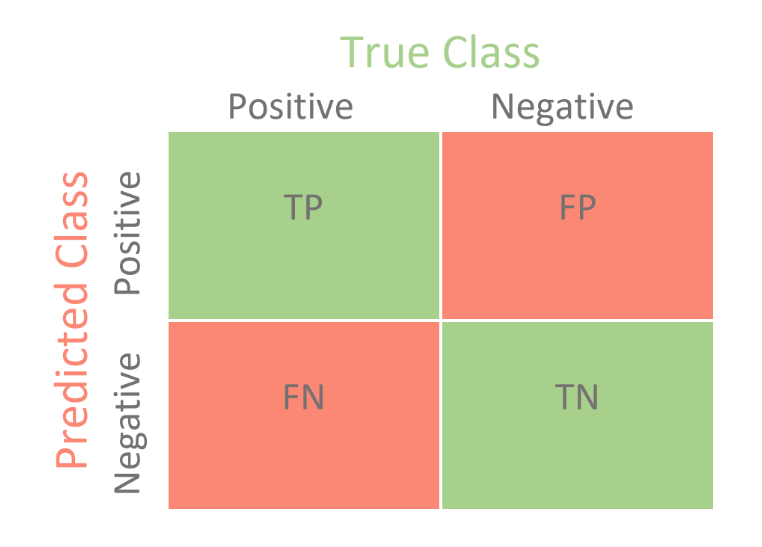  <br> (Vaddepally, 2021)

55/55 [==============================] - 1s 20ms/step


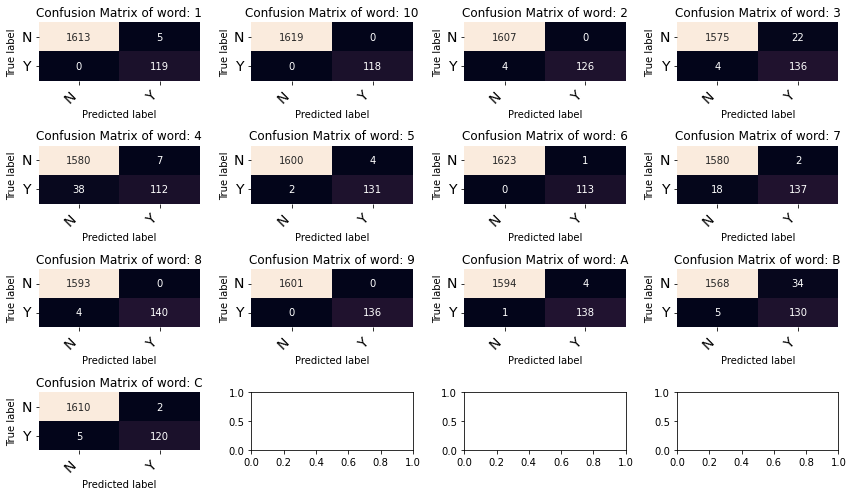

In [33]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(res, axis=1).tolist()

mlt_Cfm = multilabel_confusion_matrix(ytrue, yhat)

fig, ax = plt.subplots(4, 4, figsize=(12, 7))
  
for axes, Confusion_Matrix, label in zip(ax.flatten(), mlt_Cfm, wordList):
    show_StyledConfusionMatrix(Confusion_Matrix, axes, label, ["N", "Y"])

fig.tight_layout()
plt.show()

In [34]:
print("Mean Squared error: ", mean_squared_error(ytrue,yhat))

#average : string, [None, ‘binary’ (default), ‘micro’, ‘macro’, ‘samples’, ‘weighted’]
print(f'Model Accuracy Score: {round(accuracy_score(ytrue, yhat) * 100, 2)}%')
print(f"Precision: {precision_score(ytrue, yhat, average='micro')}")
print(f"Recall: {recall_score(ytrue, yhat, average='micro')}")
print(f"f1_score: {f1_score(ytrue, yhat, average='micro')}")

55/55 [==============================] - 1s 20ms/step
Mean Squared error:  1.4087507196315487
Model Accuracy Score: 95.34%
Precision: 0.9533678756476683
Recall: 0.9533678756476683
f1_score: 0.9533678756476683


### Vocabulary Recognition (8 categorical classes)

In [19]:
res = model.predict(X_test)
count = 0
for i in range(len(y_test)):
    testValue = np.argmax(y_test[i])
    prediciton = np.argmax(res[i])
    if prediciton != testValue:
        count = count + 1
        print(f"Expected result: {wordList[testValue]}")
        print(f"Actual result: {wordList[prediciton]}")
#         print(f"Expected result: {np.argmax(y_test[i])}")
#         print(f"Actual result: {np.argmax(res[i])}")
        print("=============================")
        
print(f'Total number of false predictions: {count}/{len(y_test)}(Total predictions made)')

7/7 [==============================] - 1s 15ms/step
Expected result: Books
Actual result: Nice
Expected result: Books
Actual result: You
Expected result: Books
Actual result: You
Expected result: You
Actual result: Meet
Expected result: Nice
Actual result: Books
Expected result: Books
Actual result: Nice
Expected result: Books
Actual result: Nice
Expected result: Books
Actual result: You
Expected result: Name
Actual result: Nice
Expected result: Books
Actual result: Nice
Total number of false predictions: 10/215(Total predictions made)


7/7 [==============================] - 0s 13ms/step


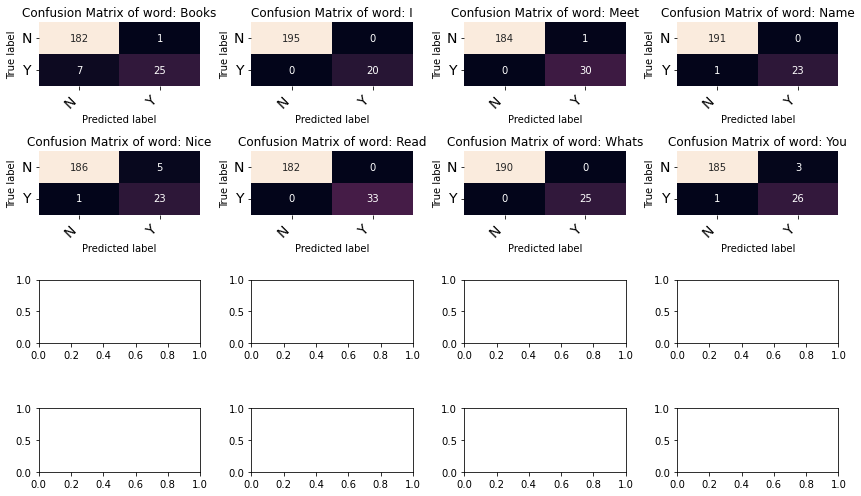

In [20]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(res, axis=1).tolist()

mlt_Cfm = multilabel_confusion_matrix(ytrue, yhat)

fig, ax = plt.subplots(4, 4, figsize=(12, 7))
  
for axes, Confusion_Matrix, label in zip(ax.flatten(), mlt_Cfm, wordList):
    show_StyledConfusionMatrix(Confusion_Matrix, axes, label, ["N", "Y"])

fig.tight_layout()
plt.show()

In [21]:
print("Mean Squared error: ", mean_squared_error(ytrue,yhat))

#average : string, [None, ‘binary’ (default), ‘micro’, ‘macro’, ‘samples’, ‘weighted’]
print(f'Model Accuracy Score: {round(accuracy_score(ytrue, yhat) * 100, 2)}%')
print(f"Precision: {precision_score(ytrue, yhat, average='micro')}")
print(f"Recall: {recall_score(ytrue, yhat, average='micro')}")
print(f"f1_score: {f1_score(ytrue, yhat, average='micro')}")

7/7 [==============================] - 0s 13ms/step
Mean Squared error:  1.1767441860465115
Model Accuracy Score: 95.35%
Precision: 0.9534883720930233
Recall: 0.9534883720930233
f1_score: 0.9534883720930233


# 9. Save Weights & Loading Model and Index Data

In [32]:
def saveModel(modelName):
    path = os.path.join(cwd, modelName, 'ASL_Word_Model.h5')
    model.save(path)

In [33]:
def loadModel(modelName):
    path = os.path.join(cwd, modelName, 'ASL_Word_Model.h5')
    model = tensorflow.keras.models.load_model(path)
    return model

# 10. Test in Real Time Recognition

In [34]:
# 1. New detection variables
sequence = [] # Add number of frames into one single data input into the model (15 frames)
modelName = 'Vocabulary LSTM Model'
wordList = list(load_label(modelName).keys())

cap = cv2.VideoCapture(cameraPort)
# Set mediapipe model 
with mediapipe_HolisticModel_Model.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as HolisticModel:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, res = mediapipe_HolisticModel_Detection(frame, HolisticModel)
        
        # 2. Prediction logic
        keypoints = get_Landmark_Values(res)
        sequence.append(keypoints)
        sequence = sequence[-frameCap:]
        
        if len(sequence) == frameCap:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            clear_output(wait=True)
            print(wordList[np.argmax(res)])            
            
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

Meet


# Natural Language Processing

We will be using an open sourced grammar and spell checking API called ginger it

In [2]:
!pip install gingerit cloudscraper 

In [46]:
import cloudscraper
from gingerit.gingerit import GingerIt
import requests
URL = "https://services.gingersoftware.com/Ginger/correct/jsonSecured/GingerTheTextFull"
API_KEY = "6ae0c3a0-afdc-4532-a810-82ded0054236"


class GingerIt(object):
    #Initialize class object
    def __init__(self):
        self.url = URL
        self.api_key = API_KEY
        self.api_version = "2.0"
        self.lang = "US"

    # Get JSON file data from API
    def getJSON_Data(self, text, verify=True):
        GingerIT_session = cloudscraper.create_scraper()
        sessionRequest = GingerIT_session.get(
            self.url,
            params={
                "lang": self.lang,
                "apiKey": self.api_key,
                "clientVersion": self.api_version,
                "text": text,
            },
            verify=verify,
        )
        data = sessionRequest.json()
        return self.process_JSON_File(text, data)
    
    # Pre-process Data from JSON file
    def process_JSON_File(self, text, data):
        result = text
        corrections = []

        for suggestion in reversed(data["Corrections"]):
            start = suggestion["From"]
            end = suggestion["To"]

            if suggestion["Suggestions"]:
                suggest = suggestion["Suggestions"][0]
                result = self.correct_GrammarSentence(result, start, end, suggest["Text"])

                corrections.append(
                    {
                        "start": start,
                        "text": text[start : end + 1],
                        "correct": suggest.get("Text", None),
                        "definition": suggest.get("Definition", None),
                    }
                )

        return {"text": text, "result": result, "corrections": corrections}
    
    # Make changes to correct sentence
    @staticmethod
    def correct_GrammarSentence(original_text, from_position, to_position, change_with):
        return "{}{}{}".format(
            original_text[:from_position], change_with, original_text[to_position + 1 :]
        )

In [47]:
def NLP_SentenceCorrection(text):
    ginger = GingerIt()
    result = ginger.getJSON_Data(text)
    return result['result']

In [48]:
print(NLP_SentenceCorrection('whats you name'))

What's your name?


### Sentence to Image Processing

Create Image to be displayed based on input words

In [49]:
from nltk.stem import PorterStemmer

Route = 'Vocabulary'
porter = PorterStemmer()
outside = os.path.normpath(cwd + os.sep + os.pardir)
videoDirectory = os.path.join(outside, 'Dataset', Route, 'video')
VideoDataset = os.listdir(videoDirectory)
print(VideoDataset)
for video in VideoDataset:

    imgFolder = os.path.join(outside, 'Dataset', 'Slides', porter.stem(video).upper())
    videoDirectory = os.path.join(outside, 'Dataset', Route, 'video', video, "video_1.mp4")
    
    isExist = os.path.exists(imgFolder)
    if isExist == True:
        print("Word {" + video + "} has already been processed!")
    else:
        count = 0
        Path(imgFolder).mkdir(parents=True, exist_ok=True)
        print(imgFolder)
        print(videoDirectory)
        cap = cv2.VideoCapture(videoDirectory)

        while True:
            try:
                ret, img = cap.read()
                count = count + 1
                cv2.imwrite(os.path.join(imgFolder,f'Img_Frame_{count}.jpg'),img)
                if count > 10:
                    cap.release()
                    cv2.destroyAllWindows()
                    break

            except Exception as e:
                print(e)
        print("==================")



['Book', 'I', 'Meet', 'Name', 'Nice', 'Read', 'Whats', 'You']
C:\Users\User\Desktop\FYP ASL Project\Project Folder\Dataset\Slides\BOOK
C:\Users\User\Desktop\FYP ASL Project\Project Folder\Dataset\Volcabulary\video\Book\video_1.mp4
C:\Users\User\Desktop\FYP ASL Project\Project Folder\Dataset\Slides\I
C:\Users\User\Desktop\FYP ASL Project\Project Folder\Dataset\Volcabulary\video\I\video_1.mp4
C:\Users\User\Desktop\FYP ASL Project\Project Folder\Dataset\Slides\MEET
C:\Users\User\Desktop\FYP ASL Project\Project Folder\Dataset\Volcabulary\video\Meet\video_1.mp4
C:\Users\User\Desktop\FYP ASL Project\Project Folder\Dataset\Slides\NAME
C:\Users\User\Desktop\FYP ASL Project\Project Folder\Dataset\Volcabulary\video\Name\video_1.mp4
C:\Users\User\Desktop\FYP ASL Project\Project Folder\Dataset\Slides\NICE
C:\Users\User\Desktop\FYP ASL Project\Project Folder\Dataset\Volcabulary\video\Nice\video_1.mp4
C:\Users\User\Desktop\FYP ASL Project\Project Folder\Dataset\Slides\READ
C:\Users\User\Desktop\FYP 

In [49]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

def NLP_SentenceProcessing(sentence):

    myTokens = []
    porter = PorterStemmer()
    sw_nltk = stopwords.words('english')
    # Tokenization
    tokenizer = RegexpTokenizer(r'\w+')
    nltk_tokens = tokenizer.tokenize(NLP_SentenceCorrection(sentence))
    allowedWords = ['i', 'what', 'you', 'your', 'name']
    
    for token in nltk_tokens:
        # Stemming
        token = porter.stem(token)
        
        # Stop words removal
        if token in sw_nltk:
            if token in allowedWords:
                myTokens.append(token)

        else:
            myTokens.append(token)

    return myTokens

NLP_SentenceProcessing(NLP_SentenceCorrection('what is your name'))    

['what', 'your', 'name']

In [50]:
def printImages(imgPath, labels):
    #imgPath = [testImgPath1, testImgPath2, testImgPath3]
    fig = plt.figure(figsize=(20, 20))
    # setting values to rows and column variables
    rows = 2
    columns = 2
    count = 0
    for testImage, word in zip(imgPath, labels):
    #for testImage in imgPath:
        print(testImage)
        count = count + 1
        myImg = cv2.imread(testImage, cv2.IMREAD_ANYCOLOR)
        fig.add_subplot(rows, columns, count)
        plt.imshow(cv2.cvtColor(myImg, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(word)

In [51]:
def getPredictedImages(inputLabels):
    outside = os.path.normpath(cwd + os.sep + os.pardir)
    path = os.path.join(outside, 'Dataset', 'Slides')

    slideLabels = os.listdir(path)
    reformat = []
    for i in slideLabels:
        arry = i.split("_")
        for x in arry:
            reformat.append(x)
    
    combined = (''.join(slideLabels)).lower()

    imgList = []
    labeledData = []
    for word in inputLabels:
        word = word.upper()
        for labels in reformat:

            if word == labels:
                imgList.append(os.path.join(outside, 'Dataset', 'Slides', labels, 'Img_Frame_7.jpg'))
                labeledData.append(word)

    return imgList, labeledData
           

C:\Users\User\Desktop\FYP ASL Project\Project Folder\Dataset\Slides\I\Img_Frame_7.jpg
C:\Users\User\Desktop\FYP ASL Project\Project Folder\Dataset\Slides\READ\Img_Frame_7.jpg
C:\Users\User\Desktop\FYP ASL Project\Project Folder\Dataset\Slides\BOOK\Img_Frame_7.jpg


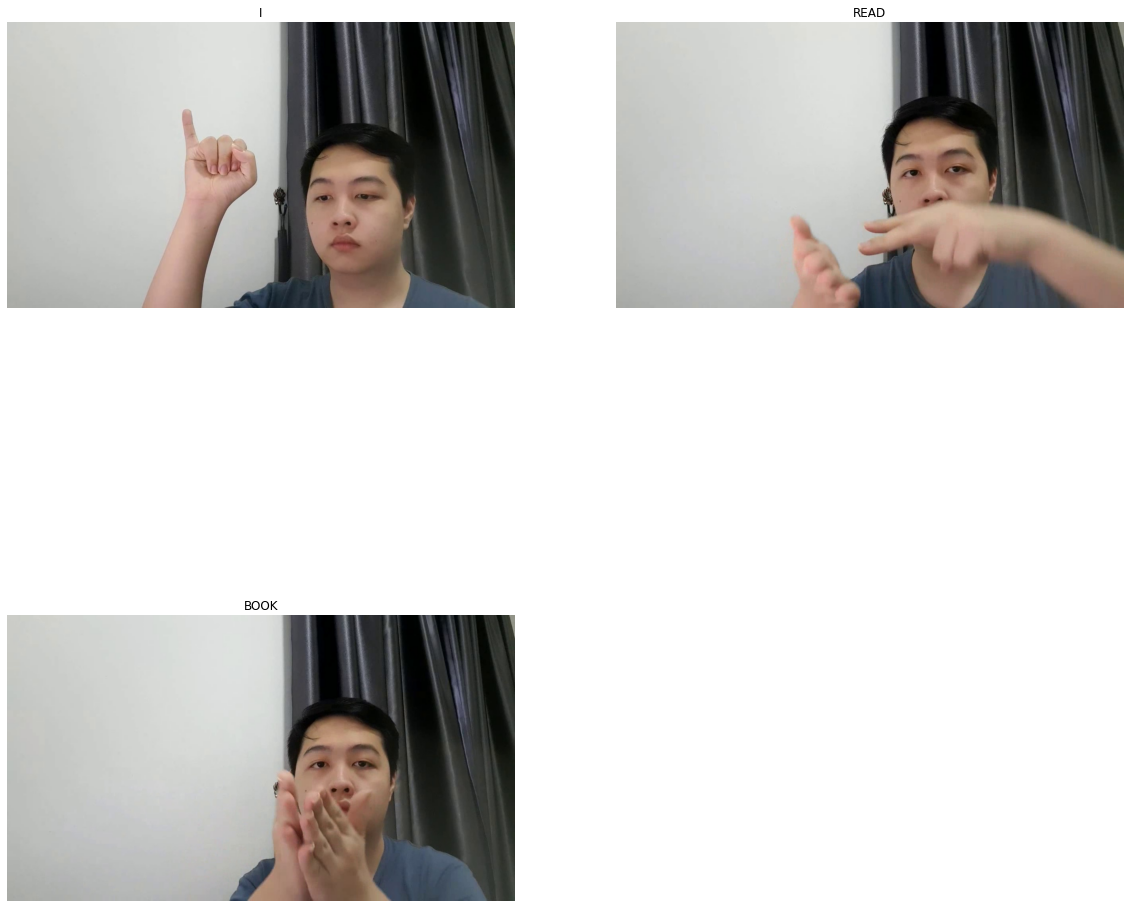

In [52]:
# Input your sentence here
mySentence = "I read books"


imgList, labeledData = getPredictedImages(NLP_SentenceProcessing(NLP_SentenceCorrection(mySentence)))

printImages(imgList, labeledData)

# 11. Real Time Sentence Translation with Prediction

### Video to Sentence

In [53]:
def listToString(array):
    mySentence = " "
    return (mySentence.join(array))

In [ ]:
# 1. New detection variables
sequence = [] # Add number of frames into one single data input into the model (15 frames)
sentence = [] # Add's a total of 3 words together
modelName = 'Vocabulary LSTM Model'
Last_predictedWord = " "
wordList = list(load_label(modelName).keys())

cap = cv2.VideoCapture(cameraPort)
# Set mediapipe model 
with mediapipe_HolisticModel_Model.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as HolisticModel:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, res = mediapipe_HolisticModel_Detection(frame, HolisticModel)
        
        # Draw landmarks
        draw_Landmarks_To_Image(image, res)
        
        # 2. Prediction logic
        keypoints = get_Landmark_Values(res)
        sequence.append(keypoints)
        sequence = sequence[-frameCap:]
        
        if len(sequence) == frameCap:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            clear_output(wait=True)
            predictedWord = wordList[np.argmax(res)]
            for num, prob in enumerate(res):
                print(f'{wordList[num]} : {round(prob*100, 2)}')
            print(f'Predicted Word: [{predictedWord}]')
            
            if len(sentence) > 3:
                # Reset predicted sentence
                sentence = []
            elif len(sentence) == 3:
                print(f'Sentence: {NLP_SentenceCorrection(listToString(sentence))}')
            
            if predictedWord != Last_predictedWord:
                Last_predictedWord = predictedWord
                sentence.append(predictedWord)
           
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

Books : 0.33
I : 0.0
Meet : 0.53
Name : 13.45
Nice : 85.61
Read : 0.0
Whats : 0.0
You : 0.09
Predicted Word: [Nice]


# Python API Code for ASL Recognition (React Website Backend)

In [9]:
def visualize_Prediction_Output(res, wordList, input_frame):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), -1)
        cv2.putText(output_frame, wordList[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [10]:
def load_label(modelName):
    path = os.path.join(cwd, modelName, 'Labels.pkl')
    with open(path, 'rb') as labelFile:
        loaded_dict = pickle.load(labelFile)
        return loaded_dict

In [11]:
# Remember to initialize the code below before running any prediction
mediapipe_HolisticModel_Model = mp.solutions.holistic # HolisticModel model
mediapipe_Draw_Landmarks = mp.solutions.drawing_utils # Drawing utilities

In [12]:
def mediapipe_HolisticModel_Detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False                 
    res = model.process(image)                
    image.flags.writeable = True                   
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, res

In [13]:
def get_Landmark_Values(res):
    leftHand = np.array([[res.x, res.y, res.z] for res in res.left_hand_landmarks.landmark]).flatten() if res.left_hand_landmarks else np.zeros(21*3)
    rightHand = np.array([[res.x, res.y, res.z] for res in res.right_hand_landmarks.landmark]).flatten() if res.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([leftHand, rightHand])

In [17]:
modelName = 'Vocabulary LSTM Model'
path = os.path.join(cwd, modelName, 'ASL_Word_Model.h5')
model = tensorflow.keras.models.load_model(path)
sequence = []

threshold = 0.5
wordList = list(load_label(modelName).keys())
cap = cv2.VideoCapture(1)

with mediapipe_HolisticModel_Model.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as HolisticModel:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, res = mediapipe_HolisticModel_Detection(frame, HolisticModel)
        
        # 2. Prediction logic
        keypoints = get_Landmark_Values(res)
        sequence.append(keypoints)
        sequence = sequence[-frameCap:]
        
        if len(sequence) == frameCap:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            clear_output(wait=True)

            # Viz probabilities
            image = visualize_Prediction_Output(res, wordList, image)

        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

1/1 [==============================] - 0s 36ms/step
